# TMLE Example Notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext line_profiler
%matplotlib inline

In [2]:
from collections import defaultdict
import copy
import gc
import logging
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.special import expit, logit
from scipy.optimize import minimize
import seaborn as sns
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
import sys
import lightgbm as lgb
from lightgbm import LGBMRegressor

/Users/jeong/.conda/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
sys.path.append('../')

In [4]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import plot
from causalml.propensity import calibrate

print(causalml.__version__)

Using TensorFlow backend.


0.5.0


In [5]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [6]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

## Calculating Individual Treatment Effect (ITE/CATE)

In [7]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y).flatten()

I1108 11:52:31.425611 4509050304 xlearner.py:171] Error metrics for group 1
I1108 11:52:31.445276 4509050304 regression.py:125]     RMSE   (Control):     4.9910
I1108 11:52:31.463823 4509050304 regression.py:126]     RMSE (Treatment):     4.9727
I1108 11:52:31.489905 4509050304 regression.py:125]    sMAPE   (Control):     1.4799
I1108 11:52:31.515150 4509050304 regression.py:126]    sMAPE (Treatment):     1.2564
I1108 11:52:31.770261 4509050304 regression.py:125]     Gini   (Control):     0.1304
I1108 11:52:31.985958 4509050304 regression.py:126]     Gini (Treatment):     0.1346


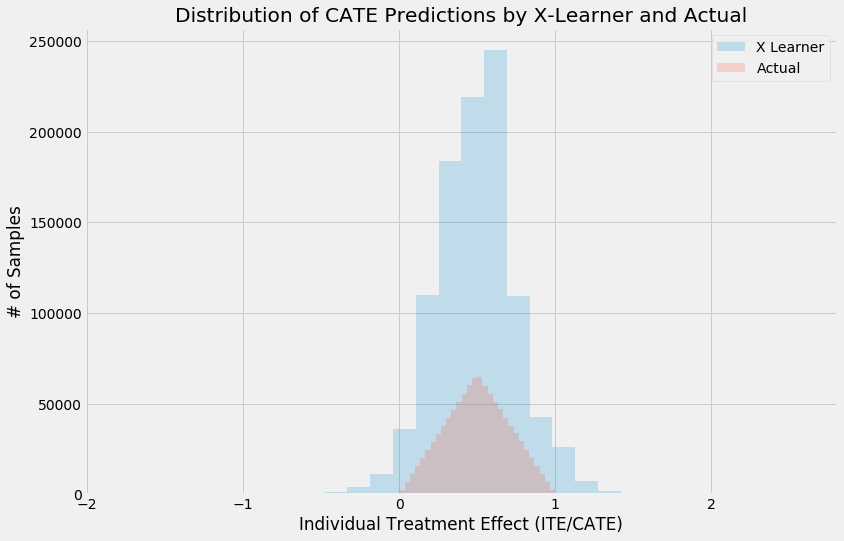

In [8]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [9]:
df = pd.DataFrame({'y': y, 'w': treatment, 'tau': tau, 'X-Learner': cate_x, 'Actual': tau})

### Uplift Curve With Ground Truth

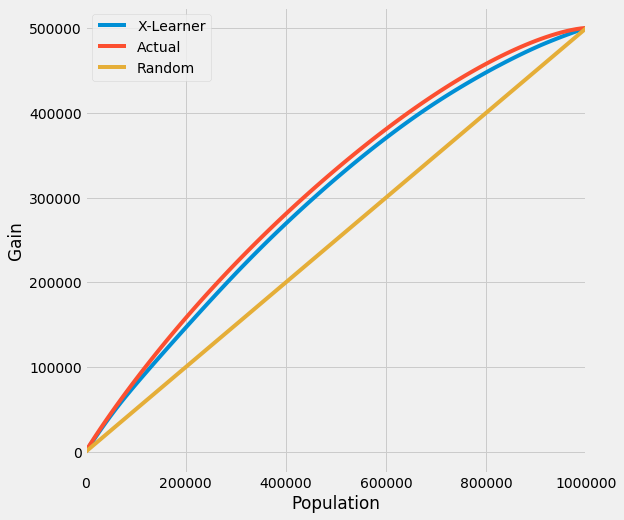

In [10]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

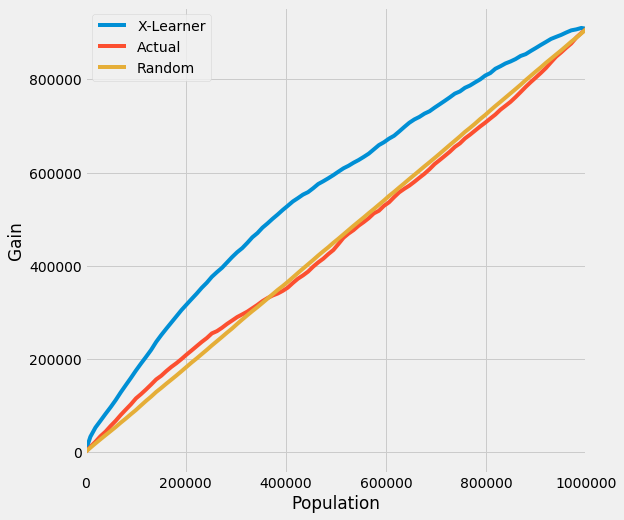

In [11]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

In [12]:
n_fold = 5
n_segment = 5

### TMLE Model Training

In [13]:
kf = KFold(n_splits=n_fold)

In [14]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_all, ate_all_lb, ate_all_ub = tmle.estimate_ate(X=X, p=e, treatment=treatment, y=y)

ate_all, ate_all_lb, ate_all_ub

I1108 11:52:41.748543 4509050304 tmle.py:124] Estimating ATE for group 1.
I1108 11:52:41.751260 4509050304 tmle.py:129] Calibrating propensity scores.
I1108 11:52:57.128440 4509050304 tmle.py:136] Training an outcome model for CV #1
I1108 11:53:02.762322 4509050304 tmle.py:136] Training an outcome model for CV #2
I1108 11:53:08.154277 4509050304 tmle.py:136] Training an outcome model for CV #3
I1108 11:53:14.386310 4509050304 tmle.py:136] Training an outcome model for CV #4
I1108 11:53:20.219980 4509050304 tmle.py:136] Training an outcome model for CV #5
I1108 11:53:25.601455 4509050304 tmle.py:149] Training the TMLE learner.


(array([0.48822999]), array([0.46125192]), array([0.51520806]))

In [15]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_actual, ate_actual_lb, ate_actual_ub = tmle.estimate_ate(X=X, p=e, treatment=treatment, y=y, segment=pd.qcut(tau, n_segment, labels=False))

ate_actual, ate_actual_lb, ate_actual_ub

I1108 11:53:26.362979 4509050304 tmle.py:124] Estimating ATE for group 1.
I1108 11:53:26.365467 4509050304 tmle.py:129] Calibrating propensity scores.
I1108 11:53:41.939907 4509050304 tmle.py:136] Training an outcome model for CV #1
I1108 11:53:47.227408 4509050304 tmle.py:136] Training an outcome model for CV #2
I1108 11:53:52.455333 4509050304 tmle.py:136] Training an outcome model for CV #3
I1108 11:53:57.661563 4509050304 tmle.py:136] Training an outcome model for CV #4
I1108 11:54:03.253355 4509050304 tmle.py:136] Training an outcome model for CV #5
I1108 11:54:08.482708 4509050304 tmle.py:161] Training the TMLE learner for segment 0.
I1108 11:54:08.647240 4509050304 tmle.py:161] Training the TMLE learner for segment 1.
I1108 11:54:08.759871 4509050304 tmle.py:161] Training the TMLE learner for segment 2.
I1108 11:54:08.879966 4509050304 tmle.py:161] Training the TMLE learner for segment 3.
I1108 11:54:09.000815 4509050304 tmle.py:161] Training the TMLE learner for segment 4.


(array([[0.20466394, 0.34420082, 0.50813071, 0.63518173, 0.76742285]]),
 array([[0.13690783, 0.29161247, 0.45856213, 0.57096387, 0.7003538 ]]),
 array([[0.27242005, 0.39678917, 0.5576993 , 0.6993996 , 0.83449189]]))

In [16]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub = tmle.estimate_ate(X=X, p=e, treatment=treatment, y=y, segment=pd.qcut(cate_x, n_segment, labels=False))

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub

I1108 11:54:09.311375 4509050304 tmle.py:124] Estimating ATE for group 1.
I1108 11:54:09.313546 4509050304 tmle.py:129] Calibrating propensity scores.
I1108 11:54:25.297245 4509050304 tmle.py:136] Training an outcome model for CV #1
I1108 11:54:30.363241 4509050304 tmle.py:136] Training an outcome model for CV #2
I1108 11:54:35.566851 4509050304 tmle.py:136] Training an outcome model for CV #3
I1108 11:54:41.212131 4509050304 tmle.py:136] Training an outcome model for CV #4
I1108 11:54:47.262089 4509050304 tmle.py:136] Training an outcome model for CV #5
I1108 11:54:53.072614 4509050304 tmle.py:161] Training the TMLE learner for segment 0.
I1108 11:54:53.235241 4509050304 tmle.py:161] Training the TMLE learner for segment 1.
I1108 11:54:53.346597 4509050304 tmle.py:161] Training the TMLE learner for segment 2.
I1108 11:54:53.451342 4509050304 tmle.py:161] Training the TMLE learner for segment 3.
I1108 11:54:53.565712 4509050304 tmle.py:161] Training the TMLE learner for segment 4.


(array([[-0.62172197,  0.27107125,  0.50191796,  0.79231564,  1.52483683]]),
 array([[-0.68715025,  0.21591944,  0.44865828,  0.72840591,  1.4619255 ]]),
 array([[-0.5562937 ,  0.32622307,  0.55517763,  0.85622536,  1.58774816]]))

### Uplift Curve with TMLE as Ground Truth

In [17]:
lift_actual = [0.] * (n_segment + 1)
lift_actual[n_segment] = ate_all[0]

lift_xlearner = [0.] * (n_segment + 1)
lift_xlearner[n_segment] = ate_all[0]

for i in range(1, n_segment):
    lift_actual[i] = ate_actual[0][n_segment - i] * .2 + lift_actual[i - 1]
    lift_xlearner[i] = ate_xlearner[0][n_segment - i] * .2 + lift_xlearner[i - 1]     

Text(0,0.5,'Lift in GB')

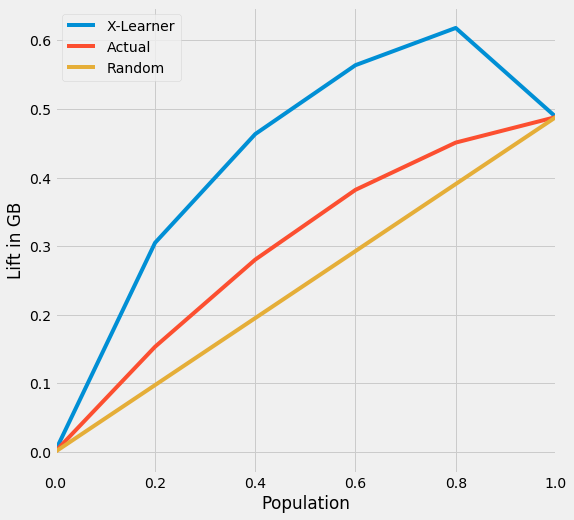

In [18]:
pd.DataFrame({'Population': np.linspace(0, 1, n_segment + 1),
              'Actual': lift_actual,
              'X-Learner': lift_xlearner,
              'Random': np.linspace(0, 1, n_segment + 1)*lift_actual[-1]}).plot(x='Population', 
                                                                                y=['X-Learner', 'Actual', 'Random'], 
                                                                                figsize=(8, 8))
plt.ylabel('Lift in GB')